In [21]:
from keras.callbacks import ModelCheckpoint
import numpy as np, pandas as pd, os, gc
import matplotlib.pyplot as plt, time
from PIL import Image 
import warnings
warnings.filterwarnings("ignore")

path = '../../input/'
train = pd.read_csv(path + 'train.csv')

# RESTRUCTURE TRAIN DATAFRAME
train['ImageId'] = train['ImageId_ClassId'].map(lambda x: x.split('.')[0]+'.jpg')
train2 = pd.DataFrame({'ImageId':train['ImageId'][::4]})
train2['e1'] = train['EncodedPixels'][::4].values
train2['e2'] = train['EncodedPixels'][1::4].values
train2['e3'] = train['EncodedPixels'][2::4].values
train2['e4'] = train['EncodedPixels'][3::4].values
train2.reset_index(inplace=True,drop=True)
train2.fillna('',inplace=True); 
train2['count'] = np.sum(train2.iloc[:,1:]!='',axis=1).values
train2.head()

ImageId                                                 e1 e2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...      
1  00031f466.jpg                                                         
2  000418bfc.jpg                                                         
3  000789191.jpg                                                         
4  0007a71bf.jpg                                                         

                                                  e3 e4  count  
0                                                            1  
1                                                            0  
2                                                            0  
3                                                            0  
4  18661 28 18863 82 19091 110 19347 110 19603 11...         1

In [3]:
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['e'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

Using TensorFlow backend.


In [5]:
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

def mask2pad(mask, pad=2):
    w = mask.shape[1]
    h = mask.shape[0]
    
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
        
    return mask

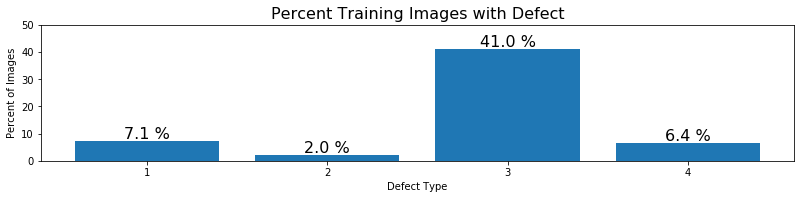

In [6]:
plt.figure(figsize=(13.5,2.5))
bar = plt.bar( [1,2,3,4],100*np.mean( train2.iloc[:,1:5]!='',axis=0) )
plt.title('Percent Training Images with Defect', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Defect Type')
plt.xticks([1,2,3,4])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=16)
plt.ylim((0,50)); plt.show()

Images and masks from our Data Generator
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


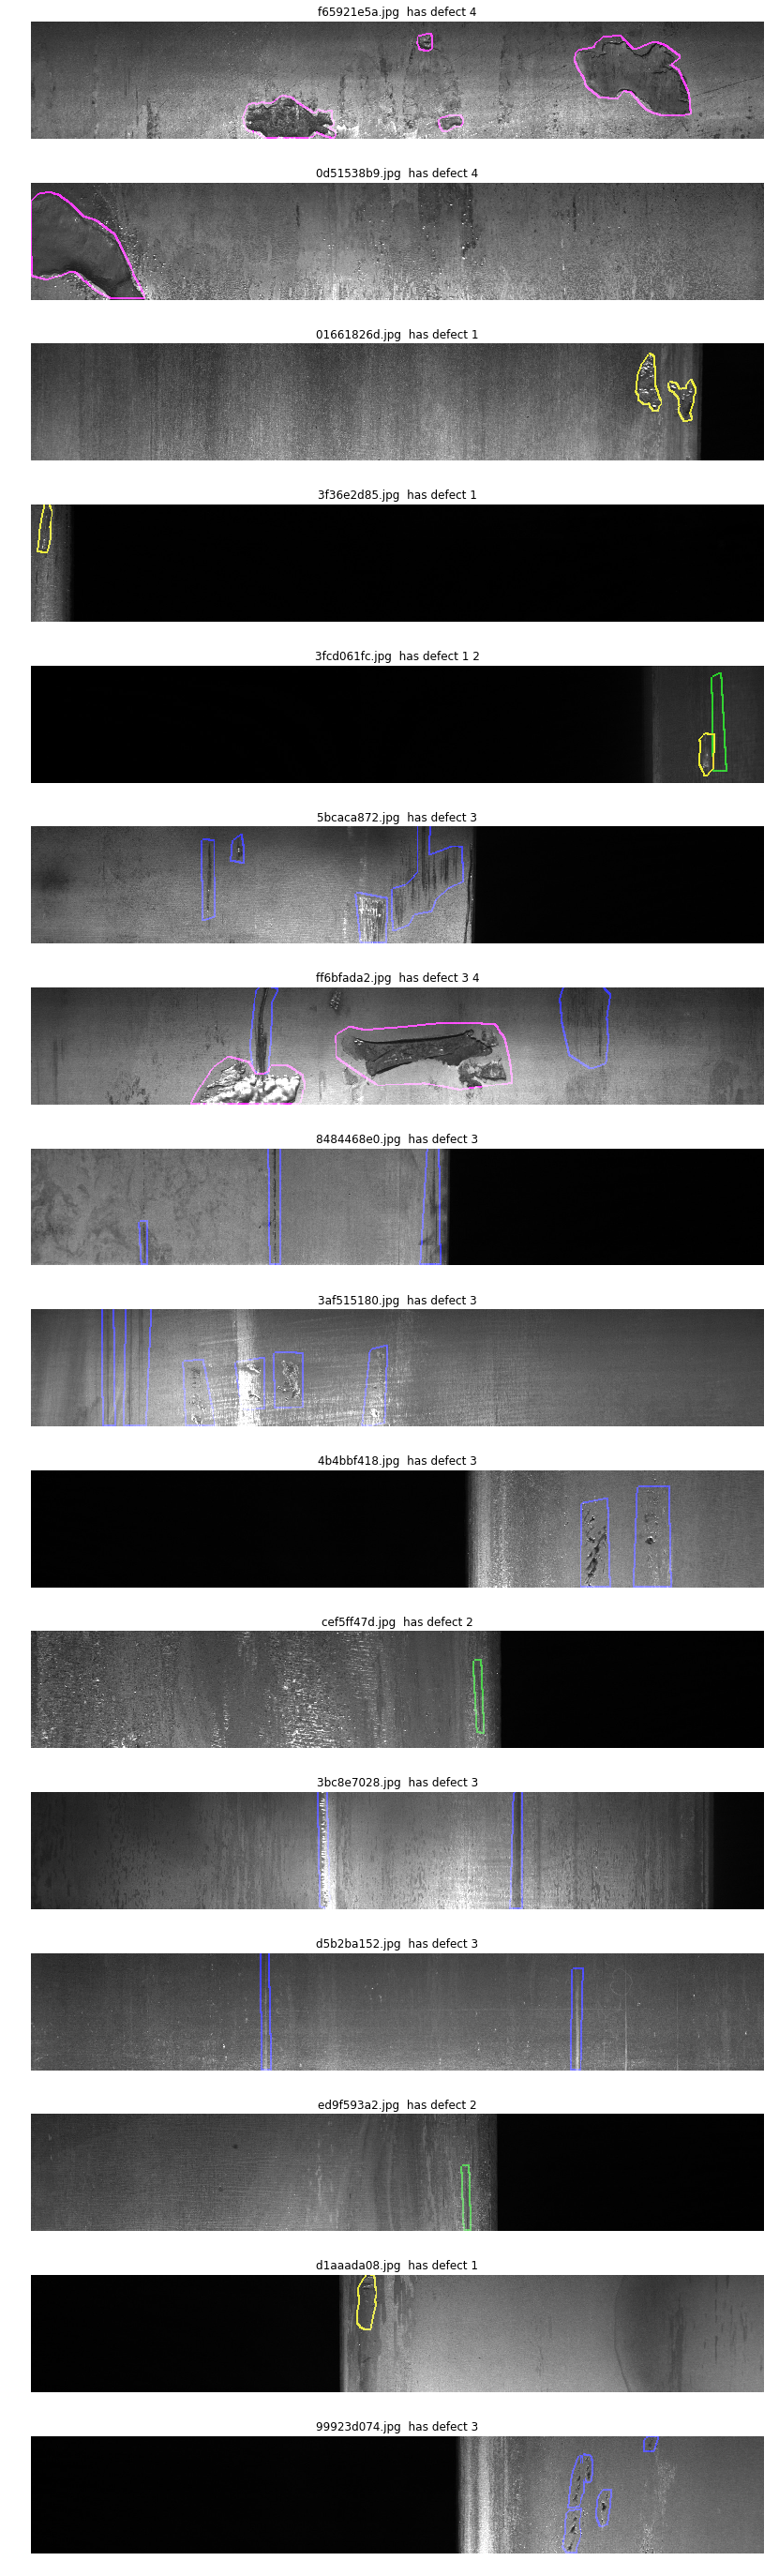

In [7]:
filenames = {}
defects = list(train2[train2['e1']!=''].sample(3).index)
defects += list(train2[train2['e2']!=''].sample(3).index)
defects += list(train2[train2['e3']!=''].sample(7).index)
defects += list(train2[train2['e4']!=''].sample(3).index)

# DATA GENERATOR
train_batches = DataGenerator(train2[train2.index.isin(defects)],shuffle=True,info=filenames)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(train_batches):
    plt.figure(figsize=(14,50)) #20,18
    for k in range(16):
        plt.subplot(16,1,k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        extra = '  has defect'
        for j in range(4):
            msk = batch[1][k,:,:,j]
            msk = mask2pad(msk,pad=3)
            msk = mask2contour(msk,width=2)
            if np.sum(msk)!=0: extra += ' '+str(j+1)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        plt.title(filenames[16*i+k]+extra)
        plt.axis('off') 
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.05)
    plt.show()

In [8]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [17]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing

preprocess=get_preprocessing('resnet34')
model=Unet('resnet34',input_shape=(128,800,3),classes=4,activation='sigmoid')
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[dice_coef])

idx=int(0.8*len(train2));print()
train_batches=DataGenerator(train2.iloc[:idx],shuffle=True,preprocess=preprocess)
valid_batches=DataGenerator(train2.iloc[idx:],preprocess=preprocess)

In [22]:
checkpoint=ModelCheckpoint('../../output/u_net.h5',monitor='val_dice_coef',save_best_only=True)
history=model.fit_generator(train_batches,validation_data=valid_batches,epochs=30,verbose=2,callbacks=[checkpoint])

Epoch 1/30
 - 623s - loss: 0.0149 - dice_coef: 0.4840 - val_loss: 0.0246 - val_dice_coef: 0.3566
Epoch 2/30
 - 623s - loss: 0.0144 - dice_coef: 0.4973 - val_loss: 0.0145 - val_dice_coef: 0.5048
Epoch 3/30
 - 624s - loss: 0.0144 - dice_coef: 0.4999 - val_loss: 0.0139 - val_dice_coef: 0.5052
Epoch 4/30
 - 623s - loss: 0.0130 - dice_coef: 0.5282 - val_loss: 0.0188 - val_dice_coef: 0.4666
Epoch 5/30
 - 623s - loss: 0.0130 - dice_coef: 0.5369 - val_loss: 0.0128 - val_dice_coef: 0.5637
Epoch 6/30
 - 623s - loss: 0.0120 - dice_coef: 0.5623 - val_loss: 0.0133 - val_dice_coef: 0.5459
Epoch 7/30
 - 623s - loss: 0.0114 - dice_coef: 0.5832 - val_loss: 0.0127 - val_dice_coef: 0.5605
Epoch 8/30
 - 622s - loss: 0.0107 - dice_coef: 0.6018 - val_loss: 0.0140 - val_dice_coef: 0.4707
Epoch 9/30
 - 623s - loss: 0.0101 - dice_coef: 0.6148 - val_loss: 0.0144 - val_dice_coef: 0.5448
Epoch 10/30
 - 623s - loss: 0.0098 - dice_coef: 0.6252 - val_loss: 0.0120 - val_dice_coef: 0.6228
Epoch 11/30
 - 623s - loss: 0

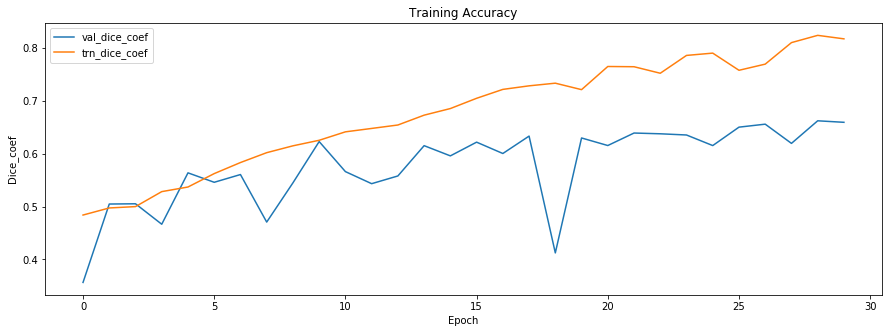

In [26]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Dice_coef')
plt.legend()
plt.show()

In [27]:
val_set=train2.iloc[idx:]
defects=list(val_set[val_set['e1'] != ''].sample(6).index)
defects+=list(val_set[val_set['e2'] != ''].sample(6).index)
defects+=list(val_set[val_set['e3'] != ''].sample(14).index)
defects+=list(val_set[val_set['e4'] != ''].sample(6).index)

valid_batches=DataGenerator(val_set[val_set.index.isin(defects)],preprocess=preprocess)
preds=model.predict_generator(valid_batches,verbose=1)

2/2 [==============================] - 4s 2s/step


Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


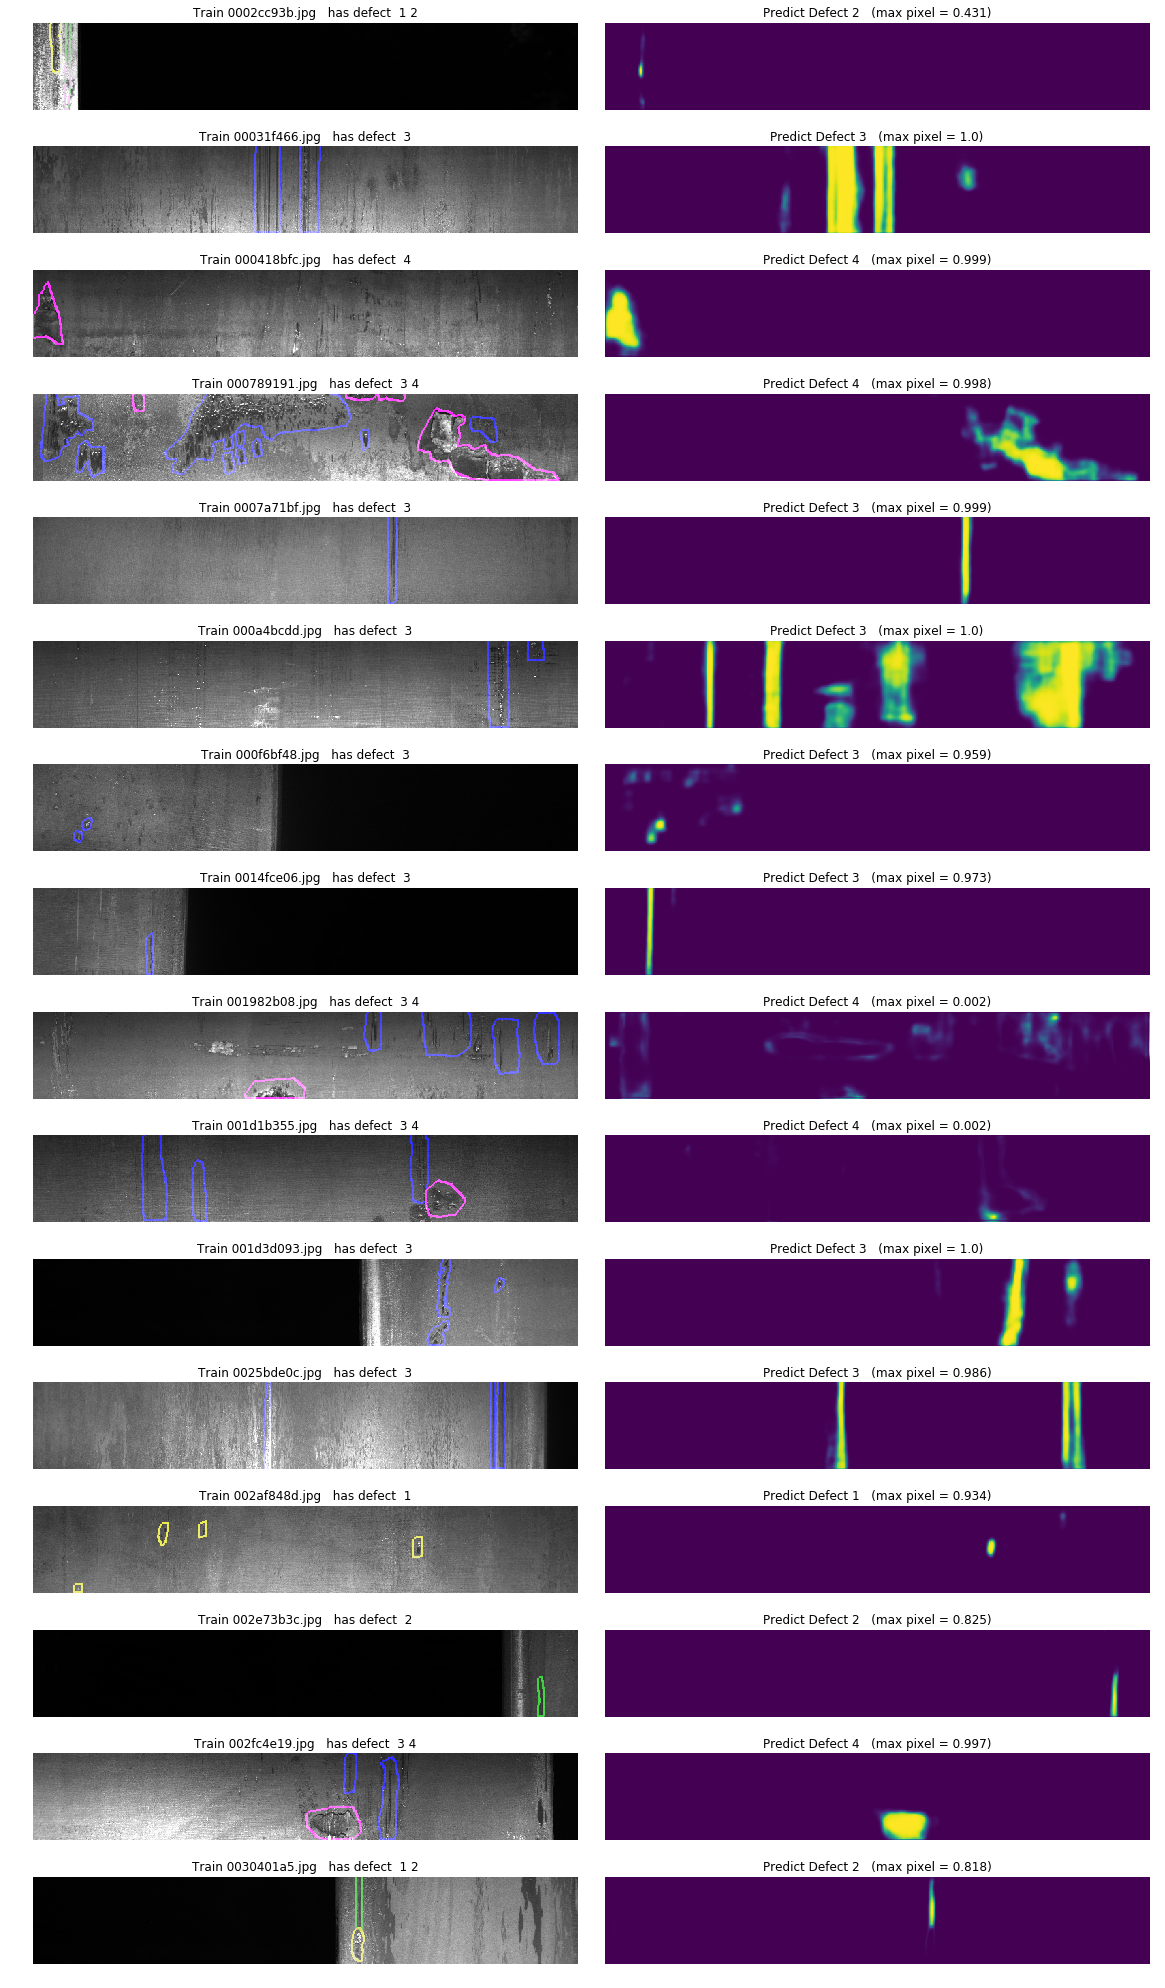

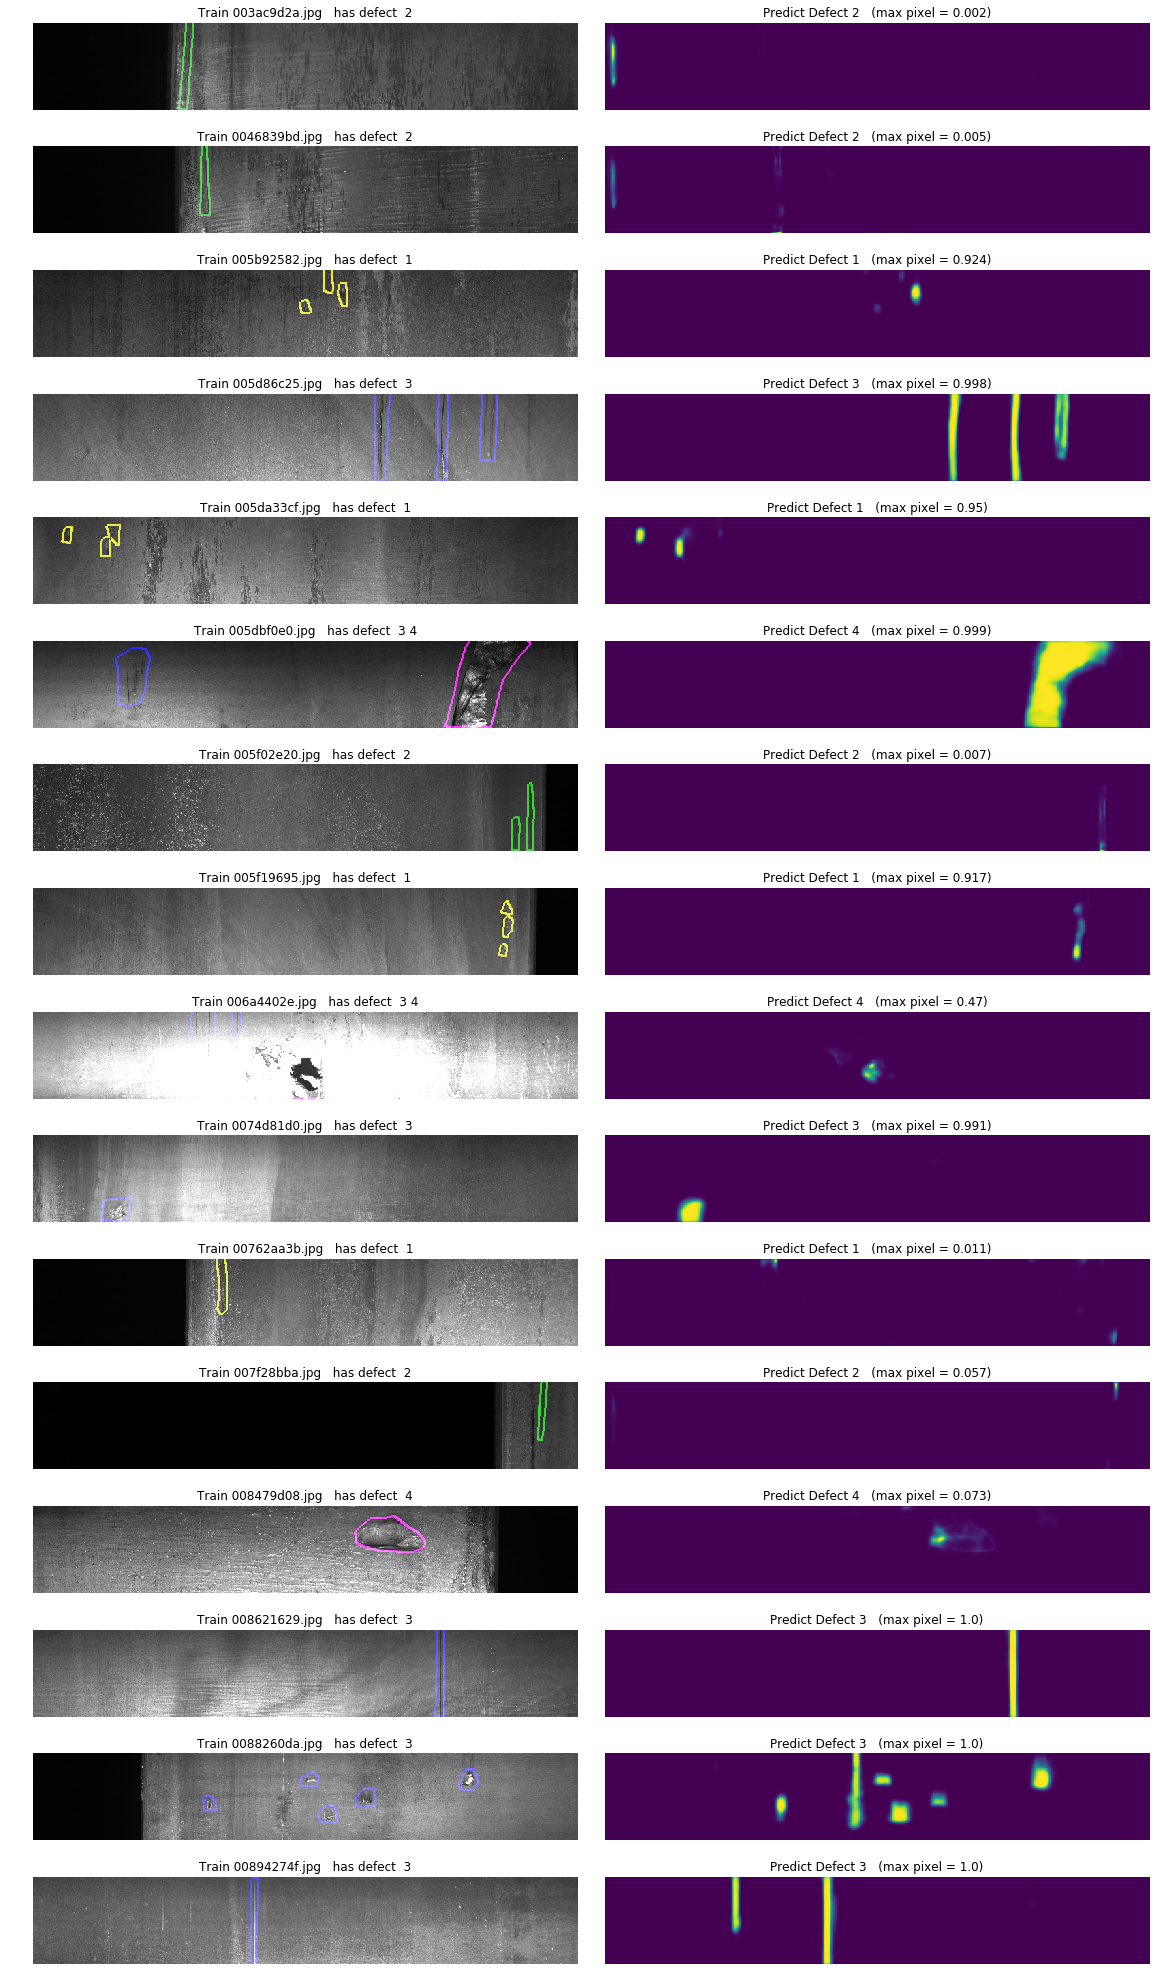

In [33]:
valid_batches=DataGenerator(val_set[val_set.index.isin(defects)])
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img=batch[0][k,]
        img=Image.fromarray(img.astype('uint8'))
        img=np.array(img)
        dft=0
        extra='   has defect '
        for j in range(4):
            msk=batch[1][k,:,:,j]
            if np.sum(msk) != 0:
                dft=j+1
                extra += ' '+str(j+1)
            msk=mask2pad(msk,pad=2)
            msk=mask2contour(msk,width=3)
            if j==0:
                img[msk==1,0]=235
                img[msk==1,1]=235
            elif j==1:
                img[msk==1,1]=210
            elif j==2:
                img[msk==1,2]=255
            elif j==3:
                img[msk==1,0]=255
                img[msk==1,2]=255
        if extra=='   has defect ':
            extra=''
        plt.title('Train '+train2.iloc[16*i+k,0]+extra)
        plt.axis('off')
        plt.imshow(img)
        plt.subplot(16,2,2*k+2)
        if dft!=0:
            msk=preds[16*i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128,800)))
        plt.axis('off')
        mx=np.round(np.max(msk),3)
        plt.title('Predict Defect '+str(dft)+'   (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

In [36]:
val_set=train2.iloc[idx:]
val_set2=val_set[(val_set['count']!=0)&(val_set['e3']=='')].sample(16)

valid_batches=DataGenerator(val_set2,preprocess=preprocess)
preds=model.predict_generator(valid_batches,verbose=1)

1/1 [==============================] - 0s 467ms/step


Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


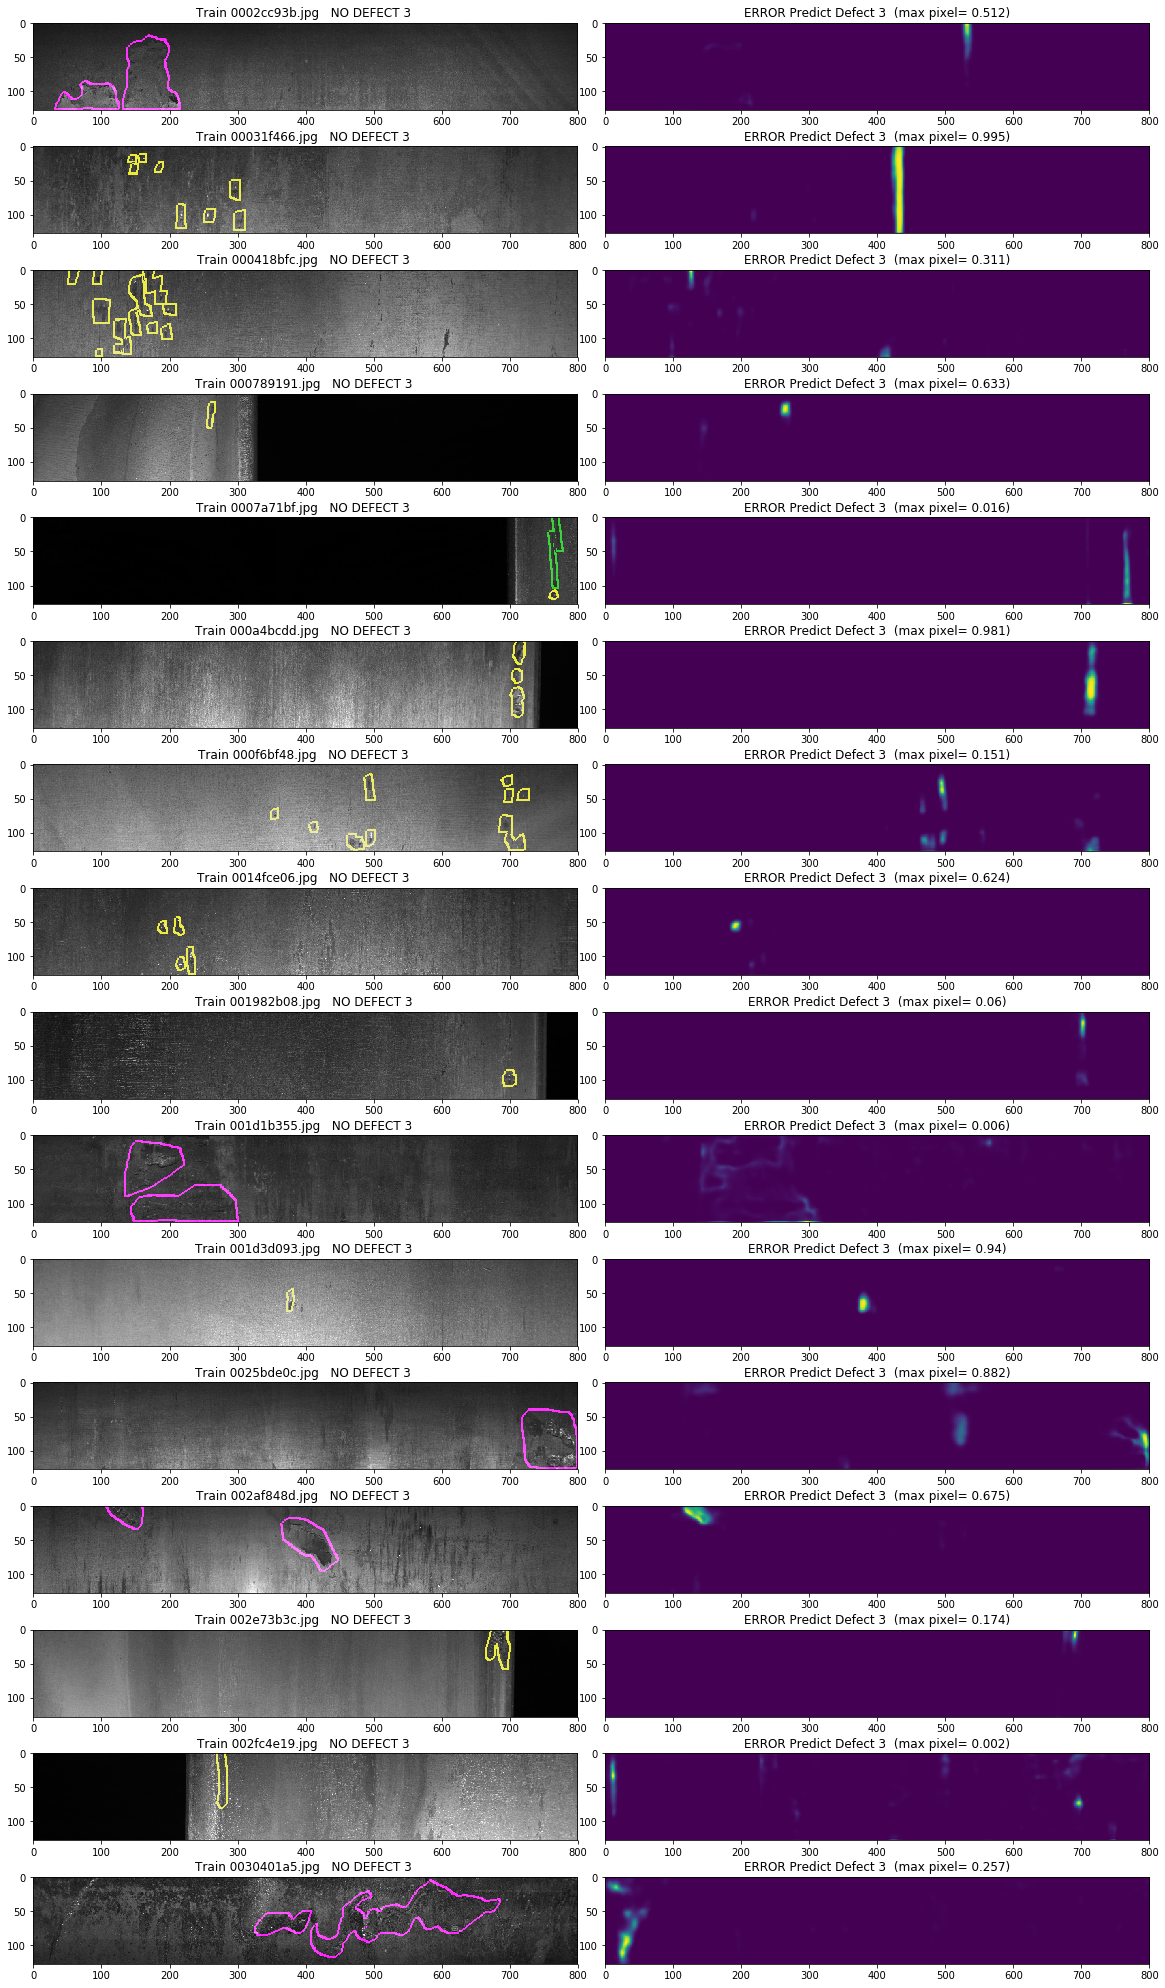

In [43]:
valid_batches=DataGenerator(val_set2)
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')
for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img=batch[0][k,]
        img=Image.fromarray(img.astype('uint8'))
        img=np.array(img)
        dft=0
        three=False
        for j in range(4):
            msk=batch[1][k,:,:,j]
            if (j==2)&(np.sum(msk)!=0):
                three=np.sum(msk)
            msk=mask2pad(msk,pad=2)
            msk=mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        extra='';extra2=''
        if not three:
            extra='NO DEFECT 3 '
            extra2='ERROR '
        plt.title('Train '+train2.iloc[16*i+k,0]+'   '+extra)
        
        plt.imshow(img)
        plt.subplot(16,2,2*k+2)
        dft=3
        if dft!=0:
            msk=preds[16*i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128,800)))
        
        mx=np.round(np.max(msk),3)
        plt.title(extra2+'Predict Defect ' +str(dft)+'  (max pixel= '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

In [44]:
valid_batches=DataGenerator(train2.iloc[idx:],preprocess=preprocess)
preds=model.predict_generator(valid_batches,verbose=1)

157/157 [==============================] - 44s 280ms/step


######################################
## Threshold = 0.1 displayed below ##
######################################


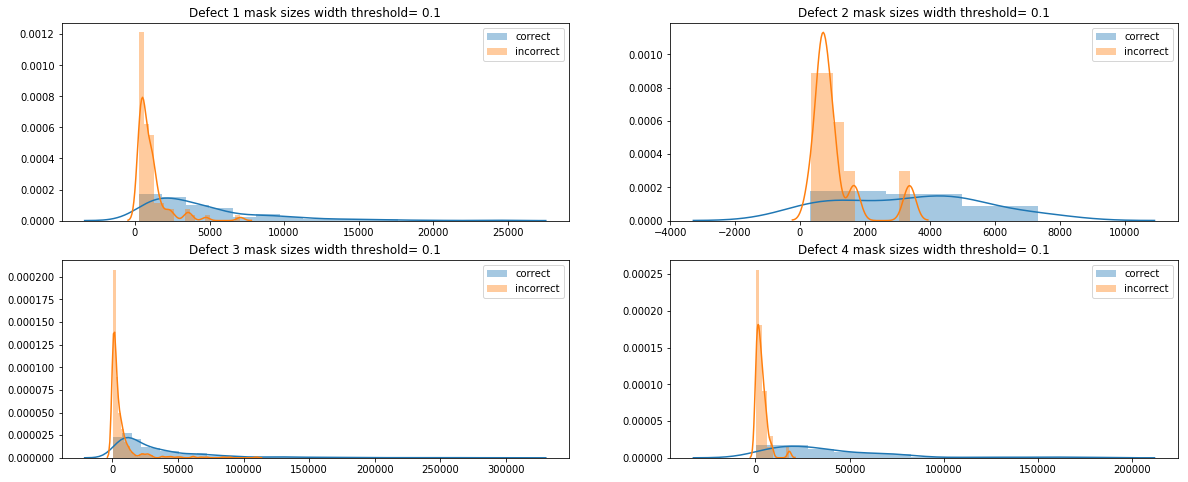

With threshold =  0.1 , defect 1 has 146 correct and 80 incorrect masks

With threshold =  0.1 , defect 2 has 29 correct and 10 incorrect masks

With threshold =  0.1 , defect 3 has 984 correct and 382 incorrect masks

With threshold =  0.1 , defect 4 has 147 correct and 45 incorrect masks

######################################
## Threshold = 0.25 displayed below ##
######################################


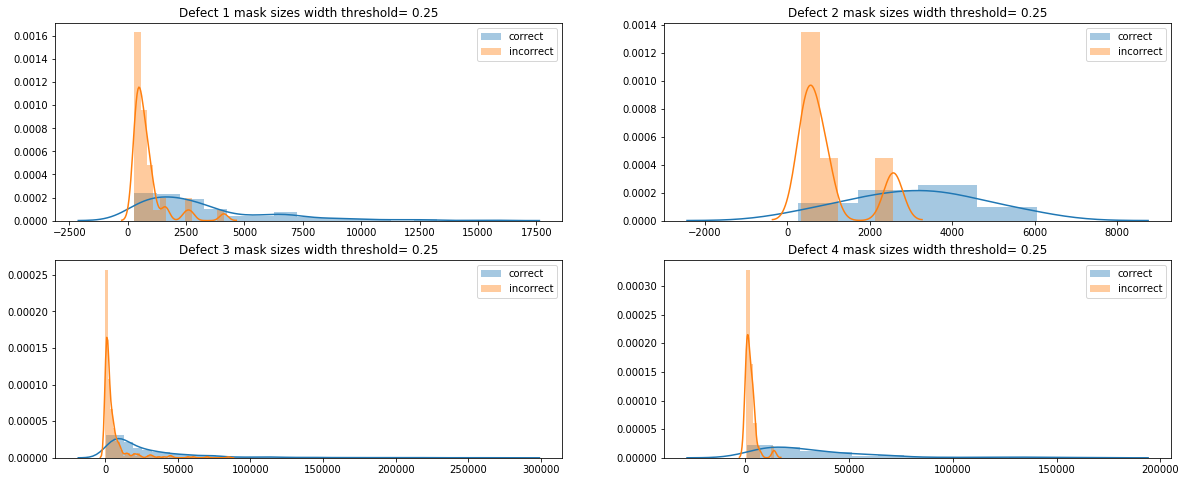

With threshold =  0.25 , defect 1 has 140 correct and 38 incorrect masks

With threshold =  0.25 , defect 2 has 22 correct and 5 incorrect masks

With threshold =  0.25 , defect 3 has 973 correct and 276 incorrect masks

With threshold =  0.25 , defect 4 has 142 correct and 29 incorrect masks

######################################
## Threshold = 0.5 displayed below ##
######################################


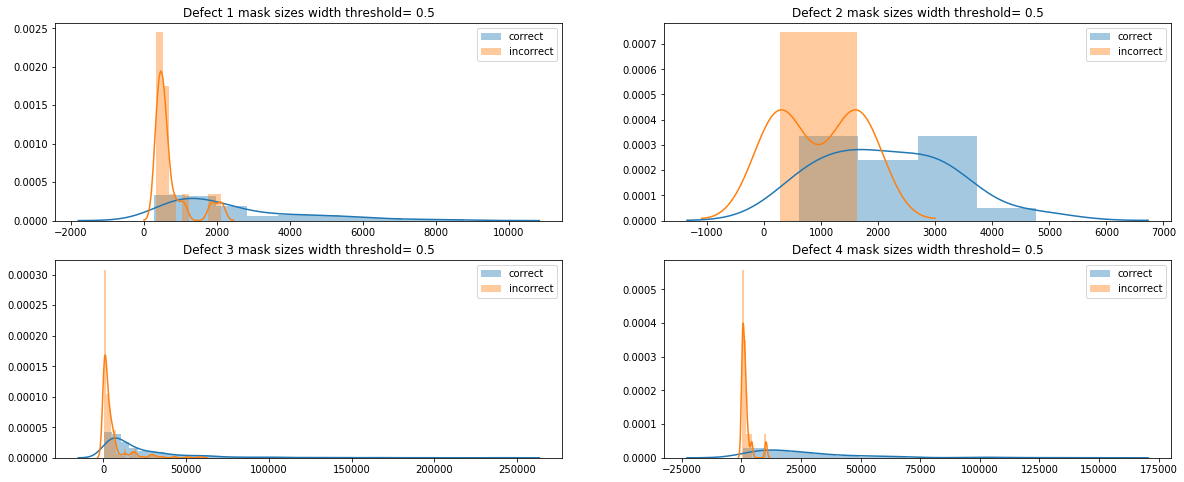

With threshold =  0.5 , defect 1 has 120 correct and 16 incorrect masks

With threshold =  0.5 , defect 2 has 20 correct and 2 incorrect masks

With threshold =  0.5 , defect 3 has 954 correct and 192 incorrect masks

With threshold =  0.5 , defect 4 has 139 correct and 17 incorrect masks

######################################
## Threshold = 0.75 displayed below ##
######################################


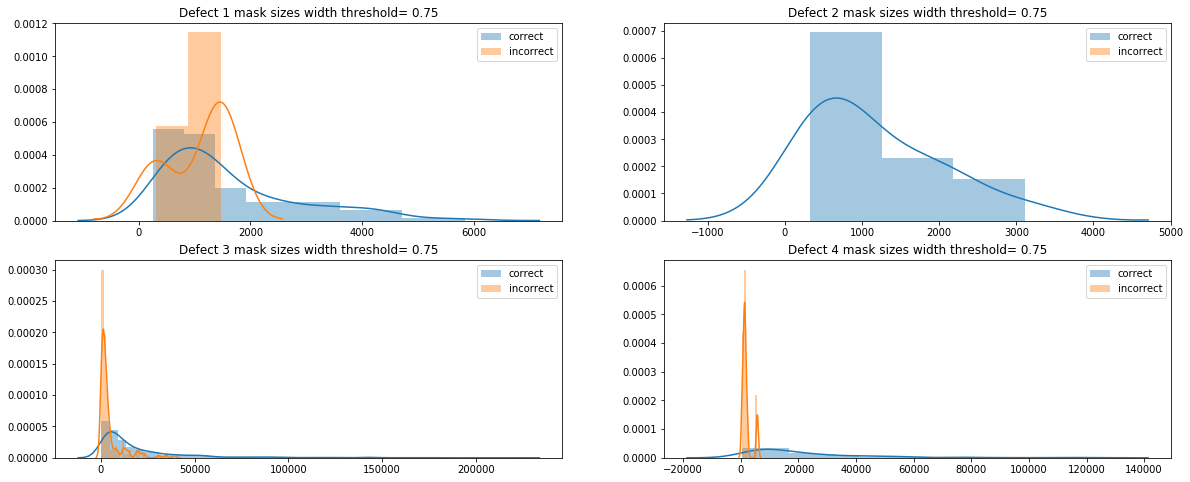

With threshold =  0.75 , defect 1 has 109 correct and 3 incorrect masks

With threshold =  0.75 , defect 2 has 14 correct and 0 incorrect masks

With threshold =  0.75 , defect 3 has 930 correct and 126 incorrect masks

With threshold =  0.75 , defect 4 has 138 correct and 7 incorrect masks

######################################
## Threshold = 0.9 displayed below ##
######################################


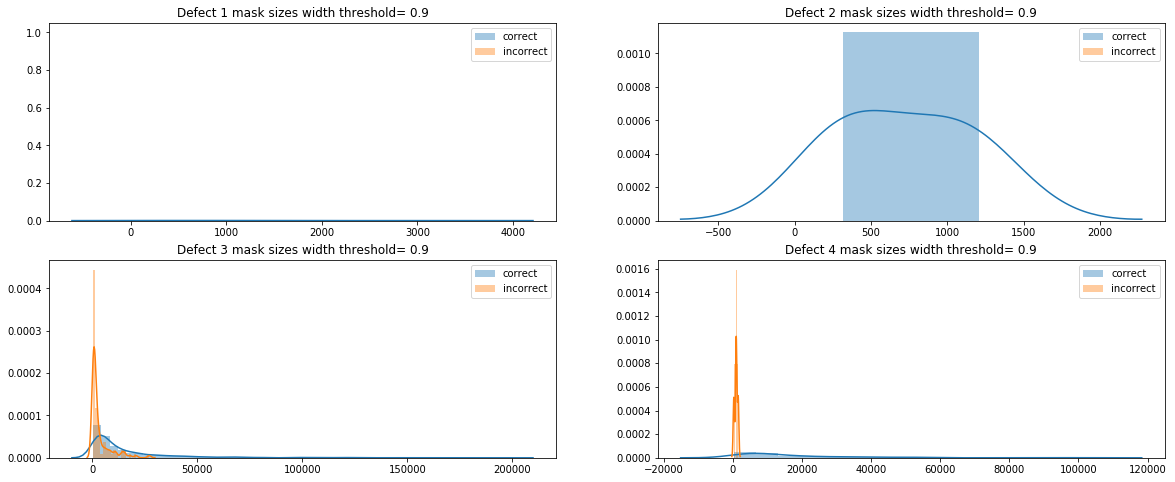

With threshold =  0.9 , defect 1 has 78 correct and 1 incorrect masks

With threshold =  0.9 , defect 2 has 4 correct and 0 incorrect masks

With threshold =  0.9 , defect 3 has 895 correct and 90 incorrect masks

With threshold =  0.9 , defect 4 has 135 correct and 4 incorrect masks



In [69]:
import seaborn as sns
pix_min = 250
for THRESHOLD in [0.1, 0.25, 0.50, 0.75, 0.9]:
    print('######################################')
    print('## Threshold =',THRESHOLD,'displayed below ##')
    print('######################################')
    correct=[[],[],[],[]]; incorrect=[[],[],[],[]]
    for i,f in enumerate(train2.iloc[idx:idx+len(preds)]['ImageId']):
        preds2 = preds[i].copy()
        preds2[preds2>=THRESHOLD]=1
        preds2[preds2<THRESHOLD]=0
        sums = np.sum(preds2,axis=(0,1))
        for j in range(4):
            if 4*sums[j]<pix_min: continue
            if train2.iloc[idx+i,j+1]=='':incorrect[j].append(4*sums[j])
            else:correct[j].append(4*sums[j])
                
    plt.figure(figsize=(20,8))
    for j in range(4):
        
        plt.subplot(2,2,j+1)
        sns.distplot([x for x in correct[j] ],label='correct')
        sns.distplot([x for x in incorrect[j] ],label='incorrect')
        plt.title('Defect '+str(j+1)+' mask sizes width threshold= '+str(THRESHOLD))
        plt.legend()
    plt.show()
    for j in range(4):
        c1=np.array(correct[j])
        c2=np.array(incorrect[j])
        print('With threshold = ',THRESHOLD,', defect',j+1,'has',len(c1[c1!=0]),
             'correct and',len(c2[c2!=0]),'incorrect masks')
        print()